In [1]:
import os
import re
import yaml
import json
import pprint
import tifffile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from src import measures
from src.separator import Separator
from src.cleaner import DoubleStepCleaner

In [299]:
main_organ = 'brain'
fpath = "/mnt/HD-LSDF/Medaka/201912_beamtime_medaka/"
cfg_path = f"/home/ws/er5241/Repos/measuring-repo/measurement_configs/measurement/{main_organ}.yaml"
db_path = "/home/ws/er5241/Repos/measuring-repo/artifacts/debug.json"

In [310]:
fls = os.listdir(fpath)
id = np.random.choice(fls)

id = 'Medaka_1105_20-1'
img_path = fpath + id + "/scaled_0.5_8bit_cropped_slices.tif"
msk_path = fpath + id + f"/{main_organ}_scaled_0.5_8bit_cropped_slices.tif"

print(id)

Medaka_1105_20-1


In [311]:
img = tifffile.imread(img_path)
msk = tifffile.imread(msk_path)

(2400, 560, 592)


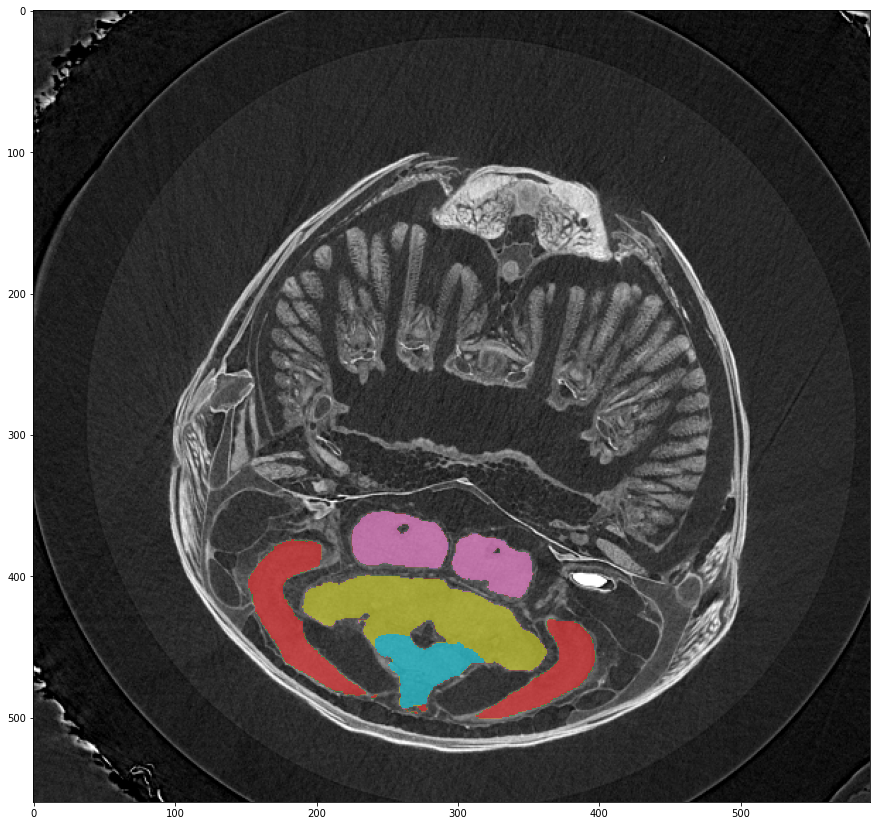

(560, 592, 2400)


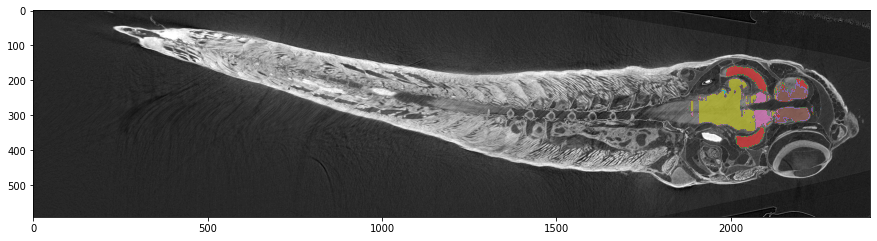

(592, 560, 2400)


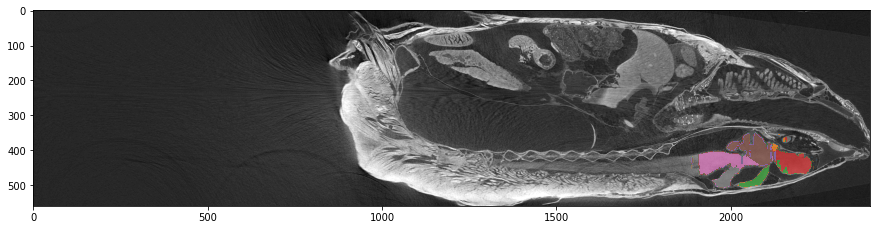

In [297]:
def plot_max(img, msk):
  for ax in range(3):
    img_swap, msk_swap = img.swapaxes(0,ax), msk.swapaxes(0,ax)
    if ax==1:
        img_swap, msk_swap = img_swap.swapaxes(1,2), msk_swap.swapaxes(1,2)
    print(img_swap.shape)
    plt.figure(figsize=(15, 15))
    
    ne_slc = np.where(msk_swap.sum((1, 2))>0)[0]
    slice_id = ne_slc[len(ne_slc)//2]
    slice_id = np.argmax(msk_swap.sum((1, 2)))
    plt.imshow(img_swap[slice_id], cmap='gray')
    plt.imshow(msk_swap[slice_id], cmap='tab10', alpha=(msk_swap[slice_id]>0)*0.7)
    
#     plt.imshow(np.max(img_swap, axis=0), cmap='gray')
#     plt.imshow(np.max(msk_swap, axis=0), cmap='tab10', alpha=(np.max(msk_swap, axis=0)>0)*0.7)
    plt.show()

plot_max(img, msk)

(2400, 560, 592)
[0 0 0]
2012


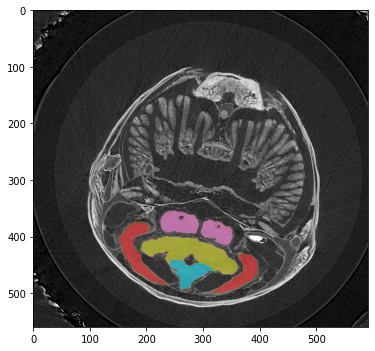

In [302]:
 def plot_slice(img, msk):
    ne_slc = np.where(msk.sum((1, 2))>0)[0]
    slice_id = ne_slc[len(ne_slc)//2]
    slice_id = np.argmax(msk.sum((1, 2)))

    print(msk.shape)
    print(np.array(msk.shape) - np.array(img.shape))
    print(slice_id)

    plt.figure(figsize=(6, 6))
    plt.imshow(img[slice_id], cmap='gray')
    plt.imshow(msk[slice_id], cmap='tab10', alpha=(msk[slice_id]>0)*0.7)
    plt.show()

plot_slice(img, msk)

In [312]:
with open(cfg_path, "r") as stream:
    configs = yaml.safe_load(stream)

cleaning_config = configs['cleaning']
pprint.pprint(cleaning_config)

{'bbox_cleaning_type': '1d',
 'bounding_boxes': 1,
 'connected_areas_per_label': [{'connected_regions': 1, 'id': 1},
                               {'connected_regions': 2, 'id': 2},
                               {'connected_regions': 1, 'id': 3},
                               {'connected_regions': 1, 'id': 4},
                               {'connected_regions': 1, 'id': 5},
                               {'connected_regions': 1, 'id': 6},
                               {'connected_regions': 1, 'id': 7},
                               {'connected_regions': 1, 'id': 8},
                               {'connected_regions': 1, 'id': 9}]}


In [313]:
cleaner = DoubleStepCleaner(**cleaning_config)

In [314]:
msk_clean, roi = cleaner(msk)
img_clean = img[roi]

print(roi)
print(msk_clean.shape)

(slice(1903, 2242, None), slice(339, 512, None), slice(151, 402, None))
(339, 173, 251)


In [315]:
counts, vals = np.unique(msk_clean, return_counts=True)
for c,v in zip(counts,vals):  print(c,':',v)

0 : 12075130
1 : 22271
2 : 719917
3 : 367718
4 : 616692
5 : 645798
6 : 263101
9 : 9770


(376, 220, 225)
[0 0 0]
151


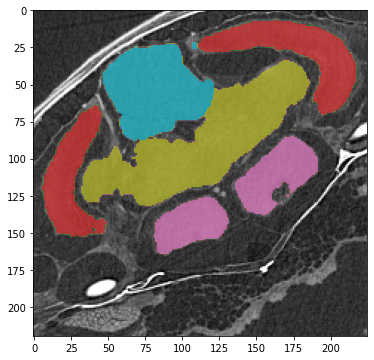

In [140]:
plot_slice(img_clean, msk_clean)

(376, 220, 225)


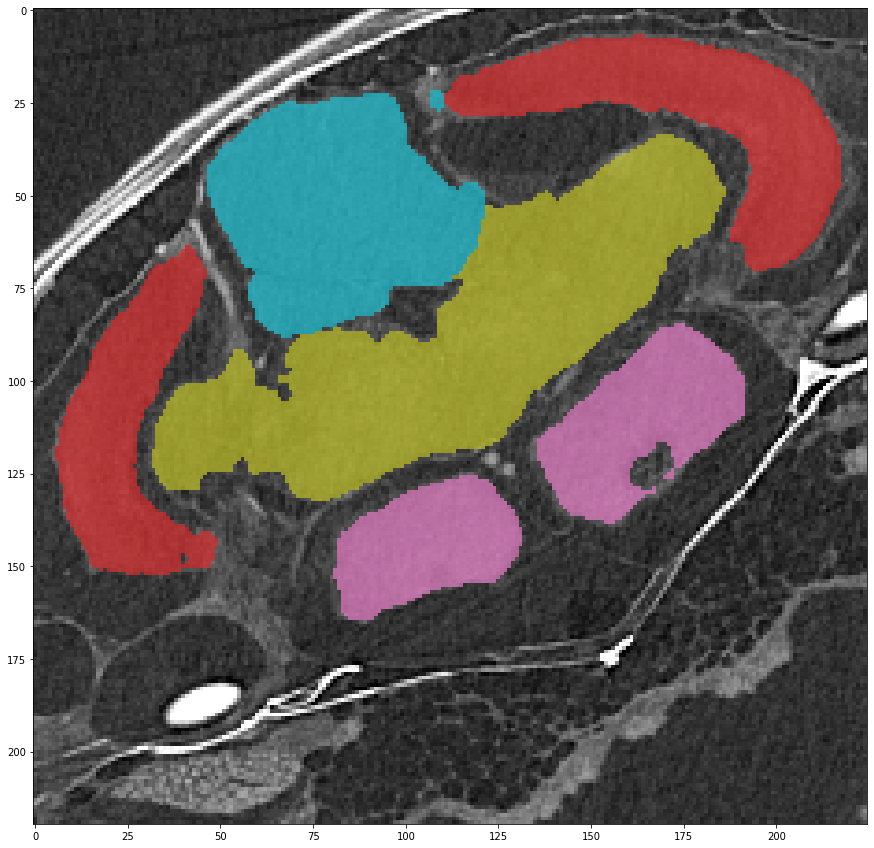

(220, 225, 376)


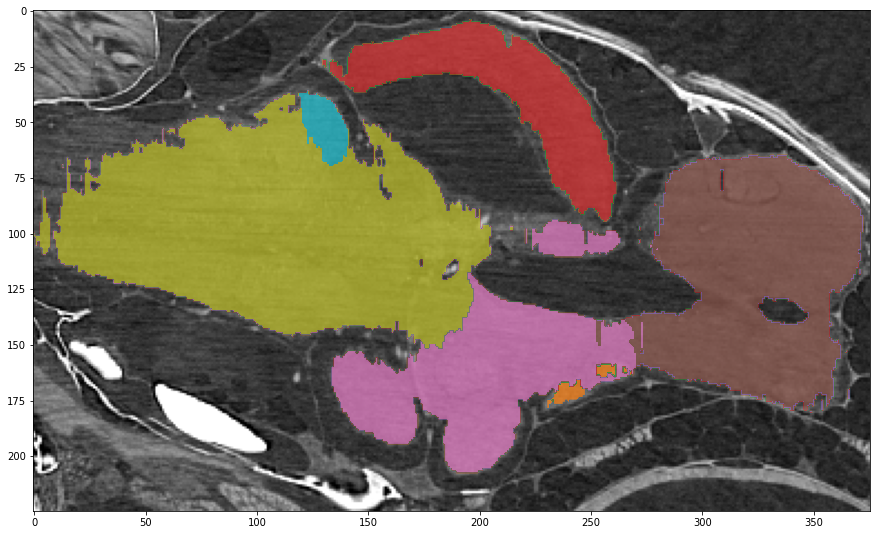

(225, 220, 376)


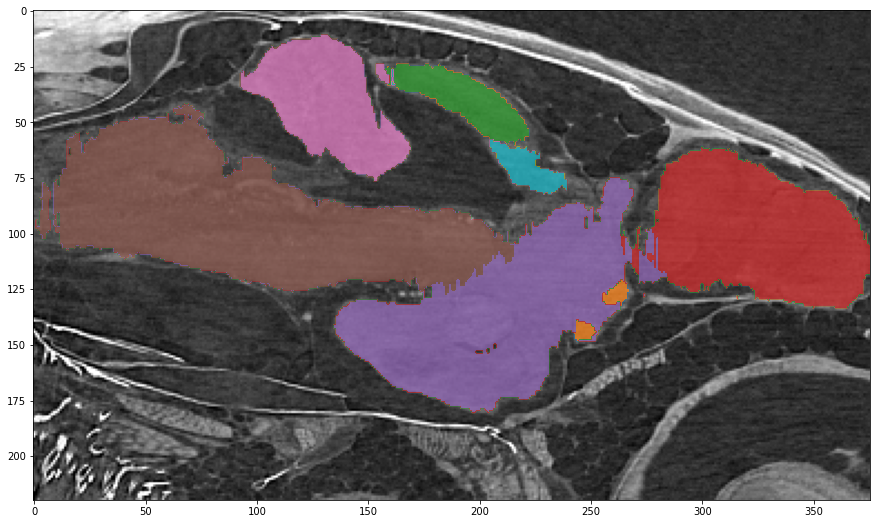

In [141]:
plot_max(img_clean, msk_clean)

In [316]:
centering_config = configs['centering'] if 'centering' in configs else []
pprint.pprint(centering_config)

centers = {}
for centering in centering_config:
    centers[centering['name']] = Separator((msk_clean == centering['label_id']), centering['function'], centering['count'])

print(centers)

[{'count': 2, 'function': 'proba', 'label_id': 2, 'name': 'optical_tectum'}]
{'optical_tectum': <src.separator.Separator object at 0x7f02e0e41310>}


In [317]:
measuring_config = configs['measures']
pprint.pprint(measuring_config)

[{'id': 1,
  'measures': [{'function': 'volume'},
               {'function': 'surface_area'},
               {'function': 'color_average'},
               {'function': 'color_std'},
               {'function': 'eccentricity_meridional'},
               {'function': 'eccentricity_equatorial'}],
  'name': 'optical_nerves'},
 {'center': 'optical_tectum',
  'id': 2,
  'measures': [{'function': 'volume'},
               {'function': 'surface_area'},
               {'function': 'color_average'},
               {'function': 'color_std'},
               {'function': 'eccentricity_meridional'},
               {'function': 'eccentricity_equatorial'},
               {'function': 'distance_between_centers'}],
  'name': 'optical_tectum'},
 {'id': 3,
  'measures': [{'function': 'volume'},
               {'function': 'surface_area'},
               {'function': 'color_average'},
               {'function': 'color_std'},
               {'function': 'eccentricity_meridional'},
               {'functio

In [25]:
import math, random
from typing import List, Tuple


def generate_polygon(center: Tuple[float, float], avg_radius: float,
                     irregularity: float, spikiness: float,
                     num_vertices: int) -> List[Tuple[float, float]]:
    """
    Start with the center of the polygon at center, then creates the
    polygon by sampling points on a circle around the center.
    Random noise is added by varying the angular spacing between
    sequential points, and by varying the radial distance of each
    point from the centre.

    Args:
        center (Tuple[float, float]):
            a pair representing the center of the circumference used
            to generate the polygon.
        avg_radius (float):
            the average radius (distance of each generated vertex to
            the center of the circumference) used to generate points
            with a normal distribution.
        irregularity (float):
            variance of the spacing of the angles between consecutive
            vertices.
        spikiness (float):
            variance of the distance of each vertex to the center of
            the circumference.
        num_vertices (int):
            the number of vertices of the polygon.
    Returns:
        List[Tuple[float, float]]: list of vertices, in CCW order.
    """
    # Parameter check
    if irregularity < 0 or irregularity > 1:
        raise ValueError("Irregularity must be between 0 and 1.")
    if spikiness < 0 or spikiness > 1:
        raise ValueError("Spikiness must be between 0 and 1.")

    irregularity *= 2 * math.pi / num_vertices
    spikiness *= avg_radius
    angle_steps = random_angle_steps(num_vertices, irregularity)

    # now generate the points
    points = []
    angle = random.uniform(0, 2 * math.pi)
    for i in range(num_vertices):
        radius = clip(random.gauss(avg_radius, spikiness), 0, 2 * avg_radius)
        point = (center[0] + radius * math.cos(angle),
                 center[1] + radius * math.sin(angle))
        points.append(point)
        angle += angle_steps[i]

    return points
  
def random_angle_steps(steps: int, irregularity: float) -> List[float]:
    """Generates the division of a circumference in random angles.

    Args:
        steps (int):
            the number of angles to generate.
        irregularity (float):
            variance of the spacing of the angles between consecutive vertices.
    Returns:
        List[float]: the list of the random angles.
    """
    # generate n angle steps
    angles = []
    lower = (2 * math.pi / steps) - irregularity
    upper = (2 * math.pi / steps) + irregularity
    cumsum = 0
    for i in range(steps):
        angle = random.uniform(lower, upper)
        angles.append(angle)
        cumsum += angle

    # normalize the steps so that point 0 and point n+1 are the same
    cumsum /= (2 * math.pi)
    for i in range(steps):
        angles[i] /= cumsum
    return angles
  
def clip(value, lower, upper):
    """
    Given an interval, values outside the interval are clipped to the interval
    edges.
    """
    return min(upper, max(value, lower))  

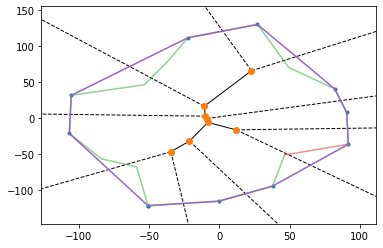

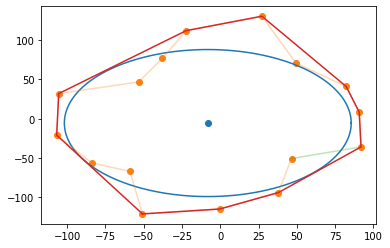

93.63187101264826 [-8.14489454 -5.57714878]


In [95]:
import alphashape
from shapely.geometry import Point


#x = np.array(generate_polygon(center=(0,0), avg_radius=100, irregularity=0.35, spikiness=0.2, num_vertices=16))

r,c = max_sphere(x,None)
print(r,c)

In [24]:
from scipy.spatial import ConvexHull, Voronoi, Delaunay, distance, voronoi_plot_2d, convex_hull_plot_2d
from tqdm.auto import tqdm
from einops import rearrange
import alphashape
from shapely.geometry import Polygon, Point, MultiPoint
import miniball

def circle(r,c):
      theta = np.linspace( 0 , 2 * np.pi , 150 )
      a = c[0] + (r * np.cos( theta ))
      b = c[1] + (r * np.sin( theta ))
      plt.scatter(c[0],c[1])
      plt.plot(a,b)

def max_sphere(markup, volume):
  mp = np.dstack(np.where(markup))[0]
  #mp=markup
  ch = alphashape.alphashape(mp,0)
  hp = np.array(ch.exterior.coords) # hull vertice coordinates
#   ch = ConvexHull(mp)
#   hp = ch.points[ch.vertices] # hull vertice coordinates
  vor = Voronoi(hp)
  vertices = vor.vertices

  # find vertex with the largest clearance radius (distance to its defining points)
  radius = 0
  for vertex in vertices:
    if ch.contains(Point(vertex)):
      distances = distance.cdist(hp, np.expand_dims(vertex,0))
      min_distance = np.min(distances)
      min_distance = ch.exterior.distance(Point(vertex))
      if min_distance > radius:
        radius,center = min_distance, vertex

#   convex_hull_plot_2d(ch)
#  voronoi_plot_2d(vor)
  plt.plot(mp[:,0],mp[:,1], alpha=0.5)
  plt.plot((mp[0,0], mp[-1,0]), (mp[0,1], mp[-1,1]), alpha=0.5)
  plt.plot(hp[:,0],hp[:,1])
  plt.plot((hp[0,0], hp[-1,0]), (hp[0,1], hp[-1,1]))
  plt.show()
  
  circle(radius, center)
  plt.scatter(mp[:,0],mp[:,1])
  plt.plot(mp[:,0],mp[:,1], alpha=0.3)
  plt.plot((mp[0,0], mp[-1,0]), (mp[0,1], mp[-1,1]), alpha=0.3)
  plt.plot(hp[:,0],hp[:,1])
  plt.plot((hp[0,0], hp[-1,0]), (hp[0,1], hp[-1,1]))
  plt.show()
  return radius, center


# x = np.zeros((10,10), dtype=bool)
# x[2,2], x[4,8], x[6,4], x[7,6], x[2,6] = True, True, True, True, True
# r,c = max_sphere(x,None)
# print(list(zip(*np.where(x))))
# plt.imshow(np.swapaxes(x,0,1),origin='lower')
# circle(r,c)

83


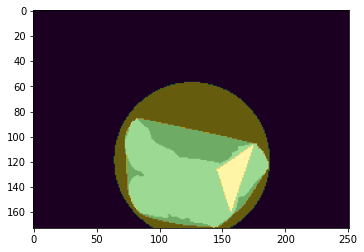

In [324]:
lbl = measuring_config[5]
label_mask = (msk_clean == lbl['id'])

mp = np.dstack(np.where(label_mask))[0]
ap = rearrange(np.indices(label_mask.shape), 'c l w h -> (l w h) c') # all volume points
# ch = alphashape.alphashape(mp,0)
# hp = np.array(ch.exterior.coords) # hull vertice coordinates
ch = ConvexHull(mp)
hp = ch.points[ch.vertices]
# print(hp.shape)

hull = Delaunay(hp) # new hull version
is_in_hull = hull.find_simplex(ap) > 0 # checking for each point if it lies on 3d 
hp_mask = rearrange(is_in_hull, '(l w h) -> l w h', l=label_mask.shape[0], w=label_mask.shape[1], h=label_mask.shape[2])

ne_slc = np.where(label_mask.sum((1, 2))>0)[0]
slice_id = ne_slc[len(ne_slc)//2]
print(slice_id)
slice_id = 83
plt.imshow(label_mask[slice_id], cmap='gray')
plt.imshow(hp_mask[slice_id], cmap='tab10', alpha=(hp_mask[slice_id]>0)*0.7)

ap = rearrange(np.indices(label_mask.shape), 'c l w h -> (l w h) c') # all volume points
min_ball = np.linalg.norm(ap - center, axis=1) <= radius
ball_mask = rearrange(min_ball, '(l w h) -> l w h', l=label_mask.shape[0], w=label_mask.shape[1], h=label_mask.shape[2])
plt.imshow(ball_mask[slice_id], alpha=0.4)

In [334]:
def radius_minimal_sphere(markup, volume):
    """Calculates radius of the minimal sphere which contains the convex hull surrounding the label"""
    mp = np.dstack(np.where(markup))[0] # marked points
    ch = ConvexHull(mp)
    hp = ch.points[ch.vertices]  # hull vertice coordinates

    C,r2 = miniball.get_bounding_ball(hp)
    return r2**0.5, C

def radius_maximal_sphere(markup, volume):
  """Calculates radius of the maximal sphere enclosed within the convex hull surrounding the label"""
  mp = np.dstack(np.where(markup))[0]
  ch = ConvexHull(mp)
  hp = ch.points[ch.vertices] # hull vertice coordinates
  hp = Polygon(hp)  # convert vertices to shapely polygon
#   ch = alphashape.alphashape(mp,0)
#   hp = np.array(ch.exterior.coords) # hull vertice coordinate
  
  vor = Voronoi(hp.exterior.coords)
  vertices = vor.vertices
  vertices = MultiPoint(vertices)

  # find vertex with the largest clearance radius (distance to its defining points)
  radius = 0
  for vertex in vertices:
    if hp.contains(vertex):
#       distances = distance.cdist(hp.exterior.coords, np.expand_dims(vertex,0))
#       min_distance = np.min(distances)
      min_distance = hp.exterior.distance(vertex)
      if min_distance > radius:
        radius,center = min_distance, np.array(vertex.coords)[0]
  return radius, center

print(radius_minimal_sphere(label_mask, None))
print(radius_maximal_sphere(label_mask, None))
radius, center = radius_maximal_sphere(label_mask, None)
print(type(radius))
radius, center = radius_minimal_sphere(label_mask, None)

(63.735785052904575, array([ 67.73855922, 118.53966645, 125.78929789]))
(5.7626000891584255, array([ 96.73076923, 136.26923077, 154.73076923]))
<class 'float'>


In [ ]:
for label in measuring_config:
    label_mask = (msk_clean == label['id'])
    print(label['id'])
    for measure in label['measures']:
        mf = getattr(measures, measure['function'])
        cc = centers[label['center']] if ('center' in label.keys()) else None
        measurement = mf(label_mask, img_clean, cc)
        print(measure['function'],measurement)

## Verify results

In [44]:
with open(cfg_path, "r") as stream:
    configs = yaml.safe_load(stream)

measuring_config = configs['measures']

In [45]:
meas_config = {}
for meas in measuring_config:
    meas_config[meas['name']] = [ m['function'] for m in meas['measures'] ]

pprint.pprint(meas_config)

{'atrium': ['volume',
            'surface_area',
            'color_average',
            'color_std',
            'eccentricity_meridional',
            'eccentricity_equatorial'],
 'left_kidney': ['volume',
                 'surface_area',
                 'color_average',
                 'color_std',
                 'eccentricity_meridional',
                 'eccentricity_equatorial'],
 'right_kidney': ['volume',
                  'surface_area',
                  'color_average',
                  'color_std',
                  'eccentricity_meridional',
                  'eccentricity_equatorial'],
 'ventricle': ['volume',
               'surface_area',
               'color_average',
               'color_std',
               'eccentricity_meridional',
               'eccentricity_equatorial']}


In [46]:
a_file = open(db_path, "r")
debug = json.load(a_file)
a_file.close()

debug = debug['_default']
keys = [str(i) for i in range(1,len(debug)+1)]

def in_nested_list(my_list):  # check for 0 or nan values
    if 0 in my_list or any([np.isnan(x).any() for x in my_list]):  return True
    else:  return any(in_nested_list(sublist) for sublist in my_list if isinstance(sublist, list))

passed_files = []
failed_files = []
fail_counts = {org : 0 for org in meas_config.keys()}
for directory in glob(f'{fpath}/Medaka_*_*/'):
    id = re.findall('/Medaka_(.*?)_.*/', directory)[0]
    debug_data = next((v for k,v in debug.items() if v['id']==id), [])
    
    if main_organ in debug_data:
        passed_files.append(id)
        main_organ_data = debug_data[main_organ]
        for sub_organ, organ_meas in main_organ_data.items():
            if set(organ_meas.keys()) != set(meas_config[sub_organ]):
                fail_counts[sub_organ] += 1
            elif in_nested_list(organ_meas.values()):
                fail_counts[sub_organ] += 1
    else:
        failed_files.append(id)

In [47]:
print(fail_counts)
print(len(failed_files))

{'atrium': 64, 'left_kidney': 54, 'ventricle': 56, 'right_kidney': 72}
54


In [48]:
lines = {}

for fl in failed_files:
    a = glob(f'{fpath}/*_{fl}*')[0]
    a = a[a.rindex('_')+1:]
    if a not in lines:
        lines[a] = 1
    else:    
        lines[a] += 1

lines = {k: v for k, v in sorted(lines.items(), key=lambda item: item[1], reverse=True)}
for k,v in lines.items():
    tot = len(glob(f'{fpath}/*{k}'))
    print(f'{k} \t{v}/{tot}')

unstained 	18/18
14-2 	6/8
eye 	3/4
131-4 	2/6
33-1 	2/8
84-2 	2/7
132-4 	2/6
13-2 	2/4
135-1 	2/6
140-3 	2/8
71-1 	2/4
25-1 	1/6
135-2 	1/5
139-4 	1/5
129-1 	1/7
55-2 	1/7
39-1 	1/7
110-2 	1/7
104-1 	1/6
117-1 	1/7
53-2 	1/7
70-2 	1/5
